In [17]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

from utils.folder import ImageFolder
from utils.common_utils import *

plt.ion()   # interactive mode

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
#         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
        transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data'
image_datasets = {x: ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=1)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

In [3]:
use_gpu

False

In [4]:
# def pil_loader(path):
#     # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
#     with open(path, 'rb') as f:
#         img = Image.open(f)
#         return img.convert('RGB')

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



_inputs.shape= torch.Size([4, 4, 995, 615])
inputs.shape= torch.Size([4, 3, 995, 615])


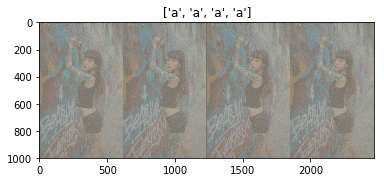

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
_inputs, classes = next(iter(dataloaders['train']))
print("_inputs.shape=",_inputs.shape)
# Make a grid from batch
inputs = _inputs[:,0:3,:,:]
print("inputs.shape=",inputs.shape)
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
class_names

['a']

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 0.0
    all_losses=[]
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            
            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs ,labels没有用，只是必须有这层结构
                _inputs, labels = data
                #把alpha通道拆出来，作为label,剩下的作为rgb3通道input
                print('_inputs.shape=',_inputs.shape)
                inputs = _inputs[:,0:3,:,:]
                labels = _inputs[:,3:4,:,:]
                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)

            epoch_loss = running_loss / dataset_sizes[phase]
            all_losses.append(epoch_loss)
            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,all_losses

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [8]:
from models.skip import skip
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'
reg_noise_std = 1./30. # set to 1./20. for sigma=50
LR = 0.01
OPTIMIZER='adam' # 'LBFGS'
show_every = 500
num_iter=2400
input_depth = 3
figsize = 5 
dtype = (torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor)

net = skip(
            input_depth, 1, 
            num_channels_down = [8, 16, 32, 64, 128], 
            num_channels_up   = [8, 16, 32, 64, 128],
            num_channels_skip = [4, 4, 4, 4, 4], 
            upsample_mode='bilinear',
            need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU')

net = net.type(dtype)
# print(net)

In [9]:
model_ft = net

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.MSELoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [10]:
model_ft,all_losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
_inputs.shape= torch.Size([4, 4, 995, 615])


/Users/roger/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


train Loss: 0.0814


/Users/roger/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


_inputs.shape= torch.Size([4, 4, 995, 615])
val Loss: 0.0786
Epoch 1/24
----------
_inputs.shape= torch.Size([4, 4, 995, 615])
train Loss: 0.0814
_inputs.shape= torch.Size([4, 4, 995, 615])
val Loss: 0.0786
Epoch 2/24
----------
_inputs.shape= torch.Size([4, 4, 995, 615])
train Loss: 0.0814
_inputs.shape= torch.Size([4, 4, 995, 615])
val Loss: 0.0786
Epoch 3/24
----------
_inputs.shape= torch.Size([4, 4, 995, 615])
train Loss: 0.0813
_inputs.shape= torch.Size([4, 4, 995, 615])
val Loss: 0.0788
Epoch 4/24
----------
_inputs.shape= torch.Size([4, 4, 995, 615])
train Loss: 0.0812
_inputs.shape= torch.Size([4, 4, 995, 615])
val Loss: 0.0789
Epoch 5/24
----------
_inputs.shape= torch.Size([4, 4, 995, 615])
train Loss: 0.0811
_inputs.shape= torch.Size([4, 4, 995, 615])
val Loss: 0.0790
Epoch 6/24
----------
_inputs.shape= torch.Size([4, 4, 995, 615])
train Loss: 0.0810
_inputs.shape= torch.Size([4, 4, 995, 615])
val Loss: 0.0794
Epoch 7/24
----------
_inputs.shape= torch.Size([4, 4, 995, 615

Process Process-30:
Traceback (most recent call last):
  File "/Users/roger/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/roger/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/roger/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/Users/roger/anaconda3/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/Users/roger/anaconda3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/Users/roger/anaconda3/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/Users/roger/anaconda3/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
Exception ig

KeyboardInterrupt: 

In [11]:
# Get a batch of training data
_inputs, classes = next(iter(dataloaders['train']))
print("_inputs.shape=",_inputs.shape)
# Make a grid from batch
inputs = _inputs[:,0:3,:,:]
outs = model_ft(inputs)



_inputs.shape= torch.Size([4, 4, 995, 615])


/Users/roger/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(4, 3, 995, 615) (4, 1, 995, 615)
inputs.shape= torch.Size([4, 3, 995, 615])


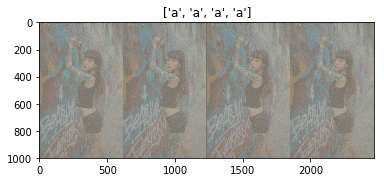

In [18]:
a,b = inputs.detach().numpy(),outs.detach().numpy()
print(a.shape,b.shape)
oo = np.concatenate((a,b),axis=1)
print("inputs.shape=",inputs.shape)
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

oo0=oo[0].squeeze()
oo_pil = np_to_pil(oo0)
oo_pil.show()